### PREDICTION CHALLENGE TASK II & III

## 1. Import Libraries, Data and Preparation

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data = pd.read_csv('Clustering_Data.csv')
data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_20,end_cluster_20
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,17,4
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,17,17
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,17,17
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,17,17
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,17,1


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17480675 entries, 0 to 17480677
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   start_station_id         float64       
 1   start_station_latitude   float64       
 2   start_station_longitude  float64       
 3   end_station_id           float64       
 4   end_station_latitude     float64       
 5   end_station_longitude    float64       
 6   bikeid                   int64         
 7   usertype                 int64         
 8   gender                   int64         
 9   start_time               datetime64[ns]
 10  stop_time                datetime64[ns]
 11  tripduration_min         float64       
 12  age                      int64         
 13  start_cluster_20         int64         
 14  end_cluster_20           int64         
dtypes: datetime64[ns](2), float64(7), int64(6)
memory usage: 2.1 GB


In [71]:
# Convert start_time and stop_time columns to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stop_time'], format="%Y-%m-%d %H:%M:%S.%f")

data = data[data['start_time'].dt.year == 2018]
data = data[data['stop_time'].dt.year == 2018]

data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_20,end_cluster_20
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,17,4
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,17,17
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,17,17
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,17,17
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,17,1


## 2. Pickups and Dropoffs Prediction 

### 2.1 NAIVE METHOD

### 2.1 Time Series Analysis Model

Given a specific cluster, we filter the data by keeping only trips whose starting station belongs to the named cluster. You can use the clusters_map.html that we created in the **Prediction_Challenge_Clustering.ipynb** notebook in order to decide what cluster you want to predict pickups and demands.

In [91]:
#We suggest clusters 2,3,15
target_clusters = [3]

data_filtered = data[data['start_cluster_20'].isin(target_clusters)].copy()

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628023 entries, 500389 to 17480662
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_station_id         628023 non-null  float64       
 1   start_station_latitude   628023 non-null  float64       
 2   start_station_longitude  628023 non-null  float64       
 3   end_station_id           628023 non-null  float64       
 4   end_station_latitude     628023 non-null  float64       
 5   end_station_longitude    628023 non-null  float64       
 6   bikeid                   628023 non-null  int64         
 7   usertype                 628023 non-null  int64         
 8   gender                   628023 non-null  int64         
 9   start_time               628023 non-null  datetime64[ns]
 10  stop_time                628023 non-null  datetime64[ns]
 11  tripduration_min         628023 non-null  float64       
 12  age           

### 2.1.1 Pickups Prediction

In [92]:
# Create pickup hour and date columns
data_filtered['pickup_hour'] = data_filtered['start_time'].dt.hour
data_filtered['date'] = data_filtered['start_time'].dt.date

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628023 entries, 500389 to 17480662
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_station_id         628023 non-null  float64       
 1   start_station_latitude   628023 non-null  float64       
 2   start_station_longitude  628023 non-null  float64       
 3   end_station_id           628023 non-null  float64       
 4   end_station_latitude     628023 non-null  float64       
 5   end_station_longitude    628023 non-null  float64       
 6   bikeid                   628023 non-null  int64         
 7   usertype                 628023 non-null  int64         
 8   gender                   628023 non-null  int64         
 9   start_time               628023 non-null  datetime64[ns]
 10  stop_time                628023 non-null  datetime64[ns]
 11  tripduration_min         628023 non-null  float64       
 12  age           

In [93]:
# Count pickups per hour, per day (for one cluster)
cluster_hourly = (
    data_filtered
    .groupby(['date', 'pickup_hour'])
    ['start_station_id']
    .size()
    .reset_index()
    .rename(columns={'start_station_id': 'pickups'})
)
cluster_hourly.head()

,date,pickup_hour,pickups
0,2018-01-01,0,7
1,2018-01-01,1,4
2,2018-01-01,2,2
3,2018-01-01,3,1
4,2018-01-01,4,2


In [94]:
cluster_hourly['datetime'] = pd.to_datetime(
    cluster_hourly['date'].astype(str) + ' ' +
    cluster_hourly['pickup_hour'].astype(str) + ':00:00'
)
cluster_hourly = cluster_hourly.sort_values('datetime')

In [95]:
# Ensure datetime index and hourly frequency
chd = (
    cluster_hourly
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'pickups': 0})  # fill missing hours if any
)

# Make sure we only keep 2018 samples
chd_2018 = chd.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data = chd.loc['2018-01-01':'2018-10-31 23:00', 'pickups']

# Test: Nov–Dec 2018
test_data  = chd.loc['2018-11-01 00:00':'2018-12-31 23:00', 'pickups']

C:\Users\billy\AppData\Local\Temp\ipykernel_12524\495717343.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


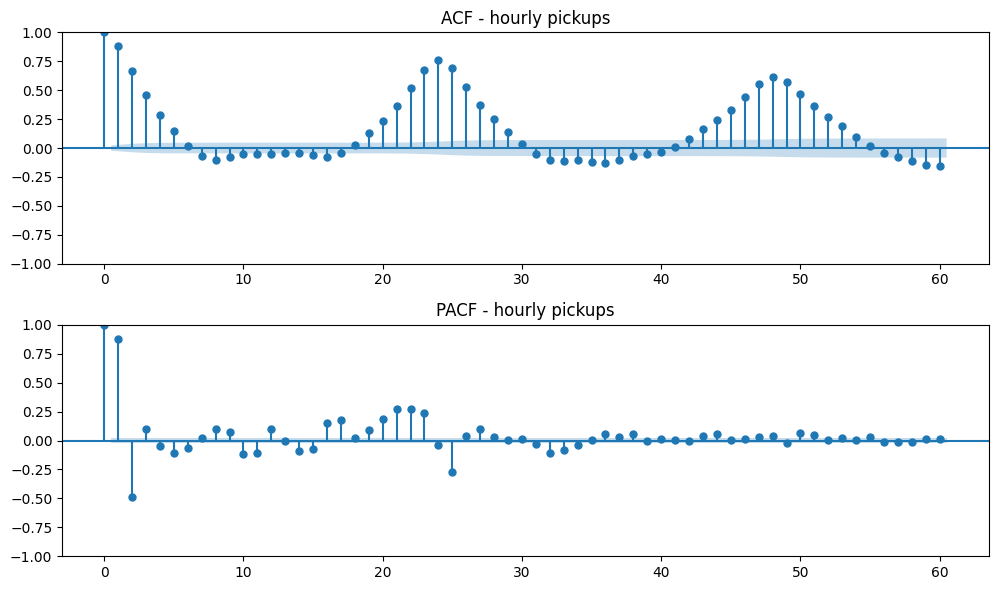

In [78]:
# Plot ACF and PACF for hourly pickups
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plt.style.use('default')
plot_acf(train_data, lags=60, ax=axes[0])
axes[0].set_title("ACF - hourly pickups")

plt.style.use('default')
plot_pacf(train_data, lags=60, ax=axes[1])
axes[1].set_title("PACF - hourly pickups")

plt.tight_layout()
plt.show()

**Non-seasonal orders**
- Looking at the PACF we see a strong spike at lag 1 with gradual decay afterwards. This observation points to AR(1) meaning p=1. 
- ACF decays from lag 1 without a sharp cutoff, so q=1
- d=1, for differencing

**Seasonal part**
- We observe waves at lags 24 and 48 in the ACF which indicates daily seasonality with period of 24 observations
- We model using one seasonal Autoregressive (AR) term, one seasonal Moving Average (MA) term plus one seasonal difference

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model for this cluster
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data.index[-1]
forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')

# Plot results
plt.style.use('default')
plt.figure(figsize=(10, 4))
plt.plot(train_data[-24*7:], label='Train')
plt.plot(test_data[:24], label='Test')
plt.plot(forecast_index, forecast, '--', label='Forecast')
plt.title('Pickup Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Pickups')
plt.legend()
plt.show()

KeyboardInterrupt: 

Mean Absolute Error for Pickups Prediction

In [40]:
y_true = chd_2018.loc['2018-11-01','pickups']
y_pred = forecast

mae = mean_absolute_error(y_true,y_pred)
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 57.27050398731557
RMSE is 64.04297205997551


### 2.1.2 Dropoffs Prediction

In [96]:
data_filtered_dropoffs = data[data['end_cluster_20'].isin(target_clusters)].copy()

data_filtered_dropoffs['dropoff_hour'] = data_filtered['stop_time'].dt.hour.astype("Int32")
data_filtered_dropoffs['date'] = data_filtered['stop_time'].dt.date

data_filtered_dropoffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631198 entries, 418 to 17480630
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_station_id         631198 non-null  float64       
 1   start_station_latitude   631198 non-null  float64       
 2   start_station_longitude  631198 non-null  float64       
 3   end_station_id           631198 non-null  float64       
 4   end_station_latitude     631198 non-null  float64       
 5   end_station_longitude    631198 non-null  float64       
 6   bikeid                   631198 non-null  int64         
 7   usertype                 631198 non-null  int64         
 8   gender                   631198 non-null  int64         
 9   start_time               631198 non-null  datetime64[ns]
 10  stop_time                631198 non-null  datetime64[ns]
 11  tripduration_min         631198 non-null  float64       
 12  age              

In [97]:
# Count dropoffs per hour, per day (for this cluster)
cluster_hourly_drops = (
    data_filtered_dropoffs
    .groupby(['date', 'dropoff_hour'])
    ['end_station_id']
    .size()
    .reset_index()
    .rename(columns={'end_station_id': 'dropoffs'})
)


In [98]:
cluster_hourly_drops['datetime'] = pd.to_datetime(
    cluster_hourly_drops['date'].astype(str) + ' ' +
    cluster_hourly_drops['dropoff_hour'].astype(str) + ':00:00'
)
cluster_hourly_drops = cluster_hourly_drops.sort_values('datetime')
cluster_hourly_drops.head()

,date,dropoff_hour,dropoffs,datetime
0,2018-01-01,0,5,2018-01-01 00:00:00
1,2018-01-01,1,2,2018-01-01 01:00:00
2,2018-01-01,2,3,2018-01-01 02:00:00
3,2018-01-01,4,2,2018-01-01 04:00:00
4,2018-01-01,5,1,2018-01-01 05:00:00


In [99]:
# Ensure datetime index and hourly frequency
chd_drop = (
    cluster_hourly_drops
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'dropoffs': 0})  # fill missing hours if any
)

# Keep only 2018 samples
chd_2018_drop = chd_drop.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data_drop = chd_2018_drop.loc['2018-01-01':'2018-10-31 23:00', 'dropoffs']
print(train_data_drop)

# Test: Nov–Dec 2018
test_data_drop  = chd_2018_drop.loc['2018-11-01 00:00':'2018-12-31 23:00', 'dropoffs']


datetime
2018-01-01 00:00:00     5.0
2018-01-01 01:00:00     2.0
2018-01-01 02:00:00     3.0
2018-01-01 03:00:00     0.0
2018-01-01 04:00:00     2.0
                       ... 
2018-10-31 19:00:00    79.0
2018-10-31 20:00:00    44.0
2018-10-31 21:00:00    35.0
2018-10-31 22:00:00    22.0
2018-10-31 23:00:00    17.0
Freq: h, Name: dropoffs, Length: 7296, dtype: float64


C:\Users\billy\AppData\Local\Temp\ipykernel_12524\490359717.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


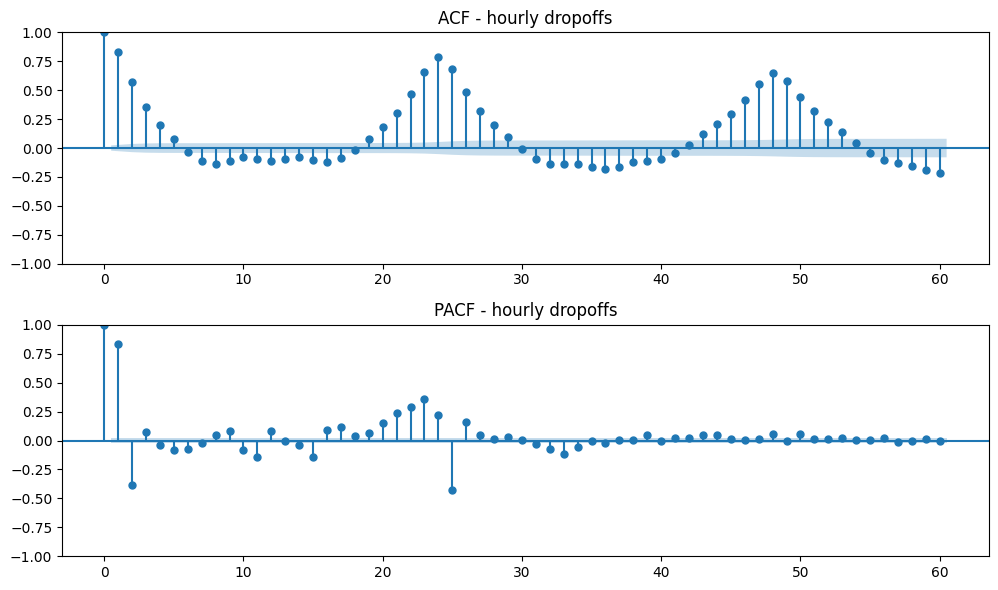

In [50]:
# Plot ACF and PACF for hourly pickups
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plt.style.use('default')
plot_acf(train_data, lags=60, ax=axes[0])
axes[0].set_title("ACF - hourly dropoffs")

plt.style.use('default')
plot_pacf(train_data, lags=60, ax=axes[1])
axes[1].set_title("PACF - hourly dropoffs")

plt.tight_layout()
plt.show()

**Non-seasonal orders**
- Looking at the PACF we see a strong spike at lag 1 with gradual decay afterwards. This observation points to AR(1) meaning p=1. 
- ACF decays from lag 1 without a sharp cutoff, so q=1
- d=1, for differencing

**Seasonal part**
- We observe waves at lags 24 and 48 in the ACF which indicates daily seasonality with period of 24 observations
- We model using one seasonal Autoregressive (AR) term, one seasonal Moving Average (MA) term plus one seasonal difference

c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\billy\AppData\Local\Temp\ipykernel_12524\1049913796.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')


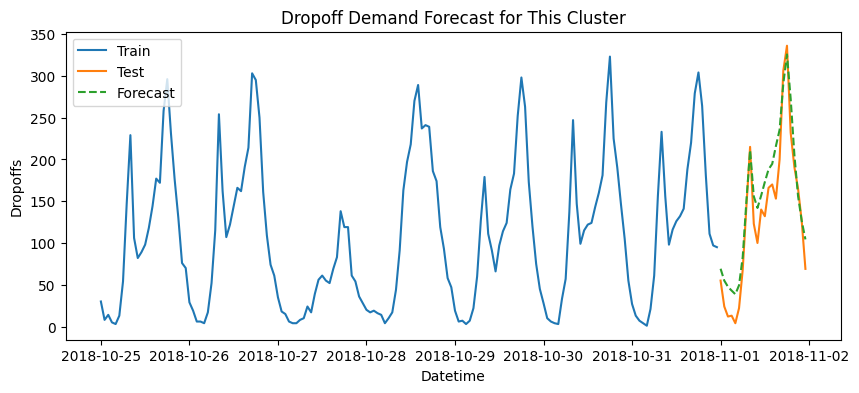

In [60]:
# Fit ARIMA model for this cluster
model = SARIMAX(train_data_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast_drop = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data_drop.index[-1]
forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')

# Plot results
plt.style.use('default')
plt.figure(figsize=(10, 4))
plt.plot(train_data_drop[-24*7:], label='Train')
plt.plot(test_data_drop[:24], label='Test')
plt.plot(forecast_drop_index, forecast_drop, '--', label='Forecast')
plt.title('Dropoff Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Dropoffs')
plt.legend()
plt.show()

In [61]:
y_true = chd_2018_drop.loc['2018-11-01','dropoffs']
y_pred = forecast_drop

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 25.059989429029315
RMSE is 29.030238463575298


## 3. Neural Networks Model

In [4]:
data_nn = data.copy()

In [5]:
data_nn['pickup_time']  = data_nn['start_time'].dt.floor('h')
data_nn['dropoff_time'] = data_nn['stop_time'].dt.floor('h')

In [6]:
pickup_ts = (
    data_nn
    .groupby(['start_cluster_20', pd.Grouper(key='pickup_time', freq='h')])
    .size()
    .rename('pickups')
    .reset_index()
    .rename(columns={'start_cluster_20': 'cluster',
                     'pickup_time': 'time'})
)

dropoff_ts = (
    data_nn
    .groupby(['end_cluster_20', pd.Grouper(key='dropoff_time', freq='h')])
    .size()
    .rename('dropoffs')
    .reset_index()
    .rename(columns={'end_cluster_20': 'cluster',
                     'dropoff_time': 'time'})
)

cluster_hour_ts = (
    pickup_ts
    .merge(dropoff_ts, on=['cluster', 'time'], how='outer')
    .fillna(0)
    .sort_values(['cluster', 'time'])
)

cluster_hour_ts.head()

,cluster,time,pickups,dropoffs
0,0,2018-01-01 00:00:00,11.0,5.0
1,0,2018-01-01 01:00:00,6.0,9.0
2,0,2018-01-01 02:00:00,5.0,7.0
3,0,2018-01-01 03:00:00,3.0,2.0
4,0,2018-01-01 05:00:00,3.0,2.0


In [7]:
cluster_hour_ts.to_csv(('cluster_hour_ts.csv'), index=False)

In [ ]:
#cluster_hour_ts = pd.read_csv('cluster_hour_ts.csv')

In [8]:
cluster_id = 15

cluster_ts = (
    cluster_hour_ts[cluster_hour_ts['cluster'] == cluster_id]
    .copy()
)

In [9]:
print(cluster_ts.head())
print(cluster_ts.shape)
print(cluster_ts.info())

cluster_ts = cluster_ts.drop(columns=['cluster'])

        cluster                time  pickups  dropoffs
120430       15 2018-01-01 00:00:00     15.0      13.0
120431       15 2018-01-01 01:00:00     28.0      32.0
120432       15 2018-01-01 02:00:00     12.0      15.0
120433       15 2018-01-01 03:00:00     12.0      14.0
120434       15 2018-01-01 04:00:00      3.0       6.0
(8740, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 8740 entries, 120430 to 129169
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cluster   8740 non-null   int64         
 1   time      8740 non-null   datetime64[ns]
 2   pickups   8740 non-null   float64       
 3   dropoffs  8740 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 341.4 KB
None


In [10]:
cluster_ts['time']=pd.to_datetime(cluster_ts['time'])
cluster_ts = cluster_ts.set_index('time').asfreq('h')
cluster_ts['pickups'] = cluster_ts['pickups'].fillna(0)
cluster_ts['dropoffs'] = cluster_ts['dropoffs'].fillna(0)

In [11]:
cluster_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Freq: h
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pickups   8760 non-null   float64
 1   dropoffs  8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


In [12]:
del pickup_ts, dropoff_ts, cluster_hour_ts

creating two separate timeseries (one for pickups and one for dropoffs)

In [13]:
df = cluster_ts.copy()
df_pickups = df[['pickups']].astype('float32')

train_val_mask = df.index <= '2018-10-31 23:00:00'

scaler = MinMaxScaler()
df_pickups.loc[train_val_mask, 'pickups'] = scaler.fit_transform(
    df_pickups.loc[train_val_mask, ['pickups']]
).ravel()
df_pickups.loc[~train_val_mask, 'pickups'] = scaler.transform(
    df_pickups.loc[~train_val_mask, ['pickups']]
).ravel()

# ----- reshape to (365, 24): each row = one day, each column = hour of the day -----
daily_pickups = df_pickups['pickups'].groupby(df_pickups.index.date).apply(list)     # 365 lists of length 24
daily_values_pickups = np.array(daily_pickups.to_list(), dtype=np.float32)   # shape (365, 24)
dates_pickups = np.array(list(daily_pickups.index))  

In [14]:
df_dropoffs = df[['dropoffs']].astype('float32')

train_val_mask = df.index <= '2018-10-31 23:00:00'

scaler = MinMaxScaler()
df_dropoffs.loc[train_val_mask, 'dropoffs'] = scaler.fit_transform(
    df_dropoffs.loc[train_val_mask, ['dropoffs']]
).ravel()
df_dropoffs.loc[~train_val_mask, 'dropoffs'] = scaler.transform(
    df_dropoffs.loc[~train_val_mask, ['dropoffs']]
).ravel()

# ----- reshape to (365, 24): each row = one day, each column = hour of the day -----
daily_dropoffs = df_dropoffs['dropoffs'].groupby(df_dropoffs.index.date).apply(list)     # 365 lists of length 24
daily_values_dropoffs = np.array(daily_dropoffs.to_list(), dtype=np.float32)   # shape (365, 24)
dates_dropoffs = np.array(list(daily_dropoffs.index))  

In [15]:
def make_samples_with_dates(daily_values, dates, input_days=7):
    """
    daily_values: (num_days, 24)
    dates:        (num_days,) datetime.date for each row in daily_values
    """
    num_days, steps_per_day = daily_values.shape

    X_train_days, y_train, train_dates = [], [], []
    X_test_days,  y_test,  test_dates  = [], [], []

    for d in range(input_days - 1, num_days - 1):  # last input day index
        x_days = daily_values[d - input_days + 1 : d + 1]    # (input_days, 24)
        target_idx = d + 1
        y_day = daily_values[target_idx]                     # (24,)
        target_date = dates[target_idx]

        if target_date <= pd.to_datetime('2018-10-31').date():
            X_train_days.append(x_days)
            y_train.append(y_day)
            train_dates.append(target_date)
        else:
            X_test_days.append(x_days)
            y_test.append(y_day)
            test_dates.append(target_date)

    return (
        np.stack(X_train_days), np.stack(y_train), np.array(train_dates),
        np.stack(X_test_days),  np.stack(y_test),  np.array(test_dates),
    )

First predicting pickups (splitting data on train and test)

In [16]:
input_days = 7 
X_train_days, y_train, train_dates, X_test_days, y_test, test_dates = make_samples_with_dates(daily_values_pickups, dates_pickups, input_days=input_days)

In [17]:
print(X_train_days.shape)
print(y_train.shape)
print(train_dates.shape)
print(X_test_days.shape)
print(y_test.shape)
print(test_dates.shape)

(297, 7, 24)
(297, 24)
(297,)
(61, 7, 24)
(61, 24)
(61,)


In [18]:
val_size = 30  # days

X_train_days_final = X_train_days[:-val_size]
y_train_final       = y_train[:-val_size]

X_val_days          = X_train_days[-val_size:]
y_val               = y_train[-val_size:]


In [19]:
print(X_train_days_final.shape)
print(y_train_final.shape)
print(X_val_days.shape)
print(y_val.shape)

(267, 7, 24)
(267, 24)
(30, 7, 24)
(30, 24)


In [20]:
steps_per_day = 24

def to_lstm_shape(X_days, input_days, steps_per_day=24):
    n_samples = X_days.shape[0]
    return X_days.reshape(n_samples, input_days * steps_per_day, 1)

In [21]:
X_train = to_lstm_shape(X_train_days_final, input_days)
X_val   = to_lstm_shape(X_val_days,        input_days)
X_test  = to_lstm_shape(X_test_days,       input_days)

# Final shapes:
# X_train: (267, 168, 1)
# y_train: (267, 24)
# X_val:   (30,  168, 1)
# y_val:   (30,  24)
# X_test:  (61,  168, 1)
# y_test:  (61,  24)


In [22]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train_final.shape)
print(y_val.shape)
print(y_test.shape)

(267, 168, 1)
(30, 168, 1)
(61, 168, 1)
(267, 24)
(30, 24)
(61, 24)


In [24]:
def build_model(units1=128, units2=64, dense_units=64,
                dropout_rate=0.2, lr=1e-3, timesteps=timesteps, n_features=n_features):
    model = Sequential([
        LSTM(units1, return_sequences=True,
             input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        LSTM(units2),
        Dense(dense_units, activation='relu'),
        Dense(24)  # 24-hour forecast
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',        # training objective
        metrics=['mae']    # monitor also MAE
    )
    return model

In [30]:
def perform_validation(timesteps=timesteps, n_features=n_features):
    configs = [
        {'u1': 64,  'u2': 32,  'dense': 32,  'drop': 0.1, 'lr': 1e-3},
        {'u1': 128, 'u2': 64,  'dense': 64,  'drop': 0.5, 'lr': 1e-3},
        {'u1': 128, 'u2': 64,  'dense': 64,  'drop': 0.3, 'lr': 5e-4},
    ]

    best_cfg = None
    best_val = np.inf
    best_epochs = None

    for cfg in configs:
        print('Config:', cfg)
        model_tmp = build_model(
            units1=cfg['u1'],
            units2=cfg['u2'],
            dense_units=cfg['dense'],
            dropout_rate=cfg['drop'],
            lr=cfg['lr'],
            timesteps=timesteps,
            n_features=n_features
        )

        es_tmp = EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=0
        )

        hist = model_tmp.fit(
            X_train, y_train_final,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            shuffle=False,
            callbacks=[es_tmp],
            verbose=1
        )

        plt.figure()
        plt.plot(hist.history['loss'], label='train MSE')
        plt.plot(hist.history['val_loss'], label='val MSE')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training vs validation loss')
        plt.show()

        val_best = min(hist.history['val_loss'])
        # epoch index of best val_loss (0-based) + 1
        epochs_used = np.argmin(hist.history['val_loss']) + 1

        print(f'  best val_loss = {val_best:.5f}, epochs_used = {epochs_used}')

        if val_best < best_val:
            best_val = val_best
            best_cfg = cfg
            best_epochs = epochs_used

    print('Best config:', best_cfg, 'val_loss:', best_val,
        'best_epochs:', best_epochs)
    
    return best_cfg, best_epochs


Config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0669 - mae: 0.1956 - val_loss: 0.0742 - val_mae: 0.2120
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0438 - mae: 0.1562 - val_loss: 0.0468 - val_mae: 0.1589
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0294 - mae: 0.1247 - val_loss: 0.0316 - val_mae: 0.1223
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0228 - mae: 0.1052 - val_loss: 0.0221 - val_mae: 0.0965
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0161 - mae: 0.0853 - val_loss: 0.0173 - val_mae: 0.0863
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0138 - mae: 0.0810 - val_loss: 0.0144 - val_mae: 0.0839
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0127 - mae: 0.0783 - val_loss: 0.0133 - val_mae: 0.0780
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0121 - mae: 0.0743 - val_loss: 0.0130 - val_mae: 0.0758
Epoch 9/50


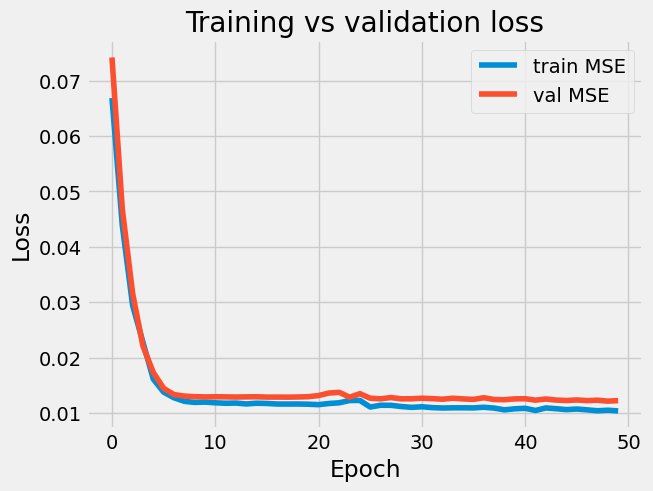

  best val_loss = 0.01212, epochs_used = 49
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.5, 'lr': 0.001}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0623 - mae: 0.1936 - val_loss: 0.0534 - val_mae: 0.1848
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0322 - mae: 0.1348 - val_loss: 0.0283 - val_mae: 0.1309
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0220 - mae: 0.1134 - val_loss: 0.0175 - val_mae: 0.0962
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0128 - mae: 0.0813 - val_loss: 0.0129 - val_mae: 0.0754
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0144 - mae: 0.0833 - val_loss: 0.0132 - val_mae: 0.0767
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0122 - mae: 0.0757 - val_loss: 0.0128 - val_mae: 0.0740
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0127 - mae: 0.0768 - val_loss: 0.0130 - val_mae: 0.0751
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0122 - mae: 0.0

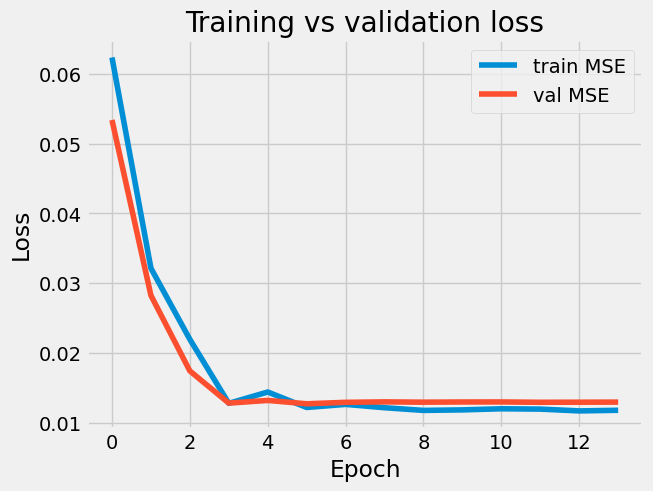

  best val_loss = 0.01276, epochs_used = 6
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.3, 'lr': 0.0005}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.0710 - mae: 0.2026 - val_loss: 0.0769 - val_mae: 0.2172
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0379 - mae: 0.1480 - val_loss: 0.0365 - val_mae: 0.1421
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0265 - mae: 0.1219 - val_loss: 0.0258 - val_mae: 0.1234
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0180 - mae: 0.0990 - val_loss: 0.0188 - val_mae: 0.0994
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0154 - mae: 0.0881 - val_loss: 0.0153 - val_mae: 0.0853
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0136 - mae: 0.0810 - val_loss: 0.0139 - val_mae: 0.0797
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0126 - mae: 0.0771 - val_loss: 0.0132 - val_mae: 0.0761
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0124 - mae: 0.0

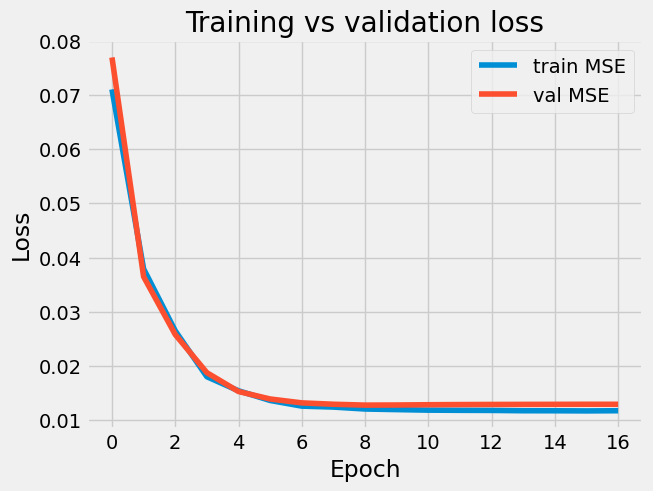

  best val_loss = 0.01278, epochs_used = 9
Best config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001} val_loss: 0.012116684578359127 best_epochs: 49


In [31]:
timesteps  = X_train.shape[1]   
n_features = X_train.shape[2]
best_cfg, best_epochs = perform_validation(timesteps, n_features)


In [32]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train_final, y_val], axis=0)

print(X_train_full.shape, y_train_full.shape)
# e.g. (297, 168, 1) and (297, 24)


(297, 168, 1) (297, 24)


In [33]:
final_model = build_model(
    units1=best_cfg['u1'],
    units2=best_cfg['u2'],
    dense_units=best_cfg['dense'],
    dropout_rate=best_cfg['drop'],
    lr=best_cfg['lr']
)

history_final = final_model.fit(
    X_train_full, y_train_full,
    epochs=best_epochs,   # from tuning
    batch_size=32,
    shuffle=False,
    verbose=1
)


Epoch 1/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0669 - mae: 0.1933
Epoch 2/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0335 - mae: 0.1404
Epoch 3/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0260 - mae: 0.1233
Epoch 4/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0193 - mae: 0.1040
Epoch 5/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0156 - mae: 0.0893
Epoch 6/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0142 - mae: 0.0833
Epoch 7/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0127 - mae: 0.0769
Epoch 8/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0128 - mae: 0.0768
Epoch 9/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0124 - mae: 0.0746
Epoch 10/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0122 - mae: 0.0735
Epoch 11/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0121 - mae: 0.0731
Epoch 12/49
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0120 - mae: 0.0725
Epoch 13/49
10/10 ━━━━━━━━━━━━━━━━━━━

In [34]:
y_pred_scaled = final_model.predict(X_test)   # shape (N_test, 24)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step


In [35]:
# y_test and y_pred_scaled are in [0,1] (scaled)
# we need 2D arrays for scaler.inverse_transform

y_test_flat_scaled = y_test.reshape(-1, 1)
y_pred_flat_scaled = y_pred_scaled.reshape(-1, 1)

y_test_flat = scaler.inverse_transform(y_test_flat_scaled).ravel()
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).ravel()

# reshape back to (N_days, 24)
y_test_inv = y_test_flat.reshape(y_test.shape)
y_pred_inv = y_pred_flat.reshape(y_pred_scaled.shape)


In [36]:
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae  = mean_absolute_error(y_test_flat, y_pred_flat)

print(f'Overall RMSE: {rmse:.2f}')
print(f'Overall MAE:  {mae:.2f}')


Overall RMSE: 131.81
Overall MAE:  87.73


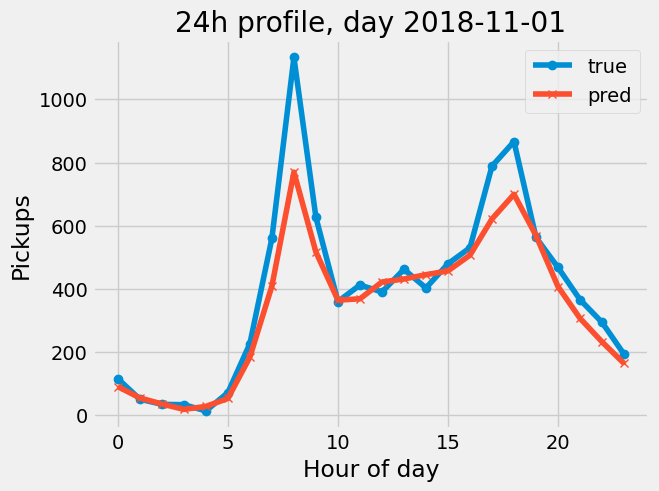

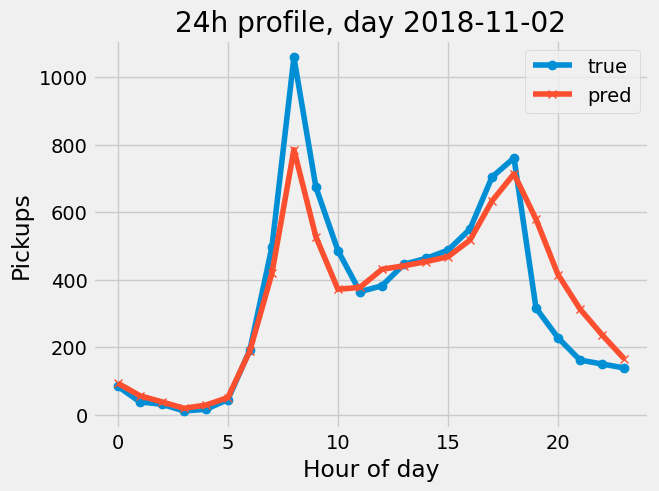

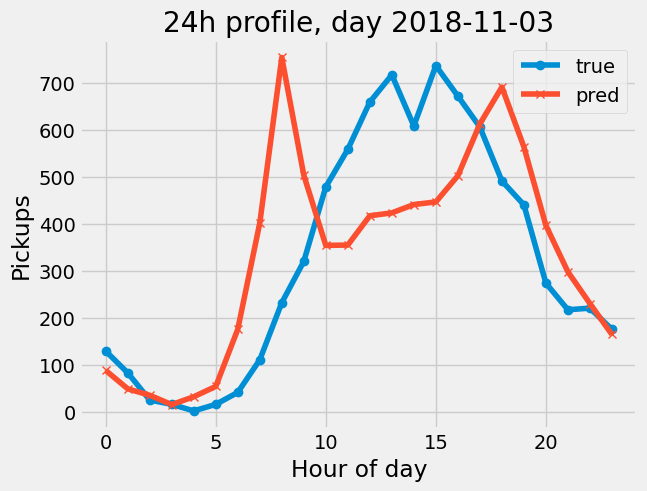

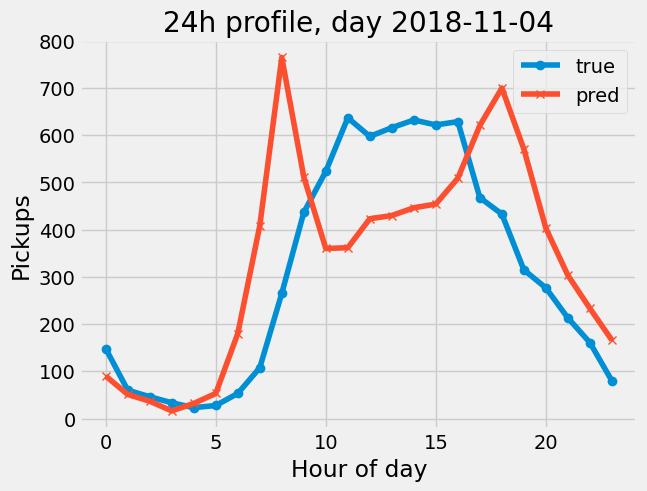

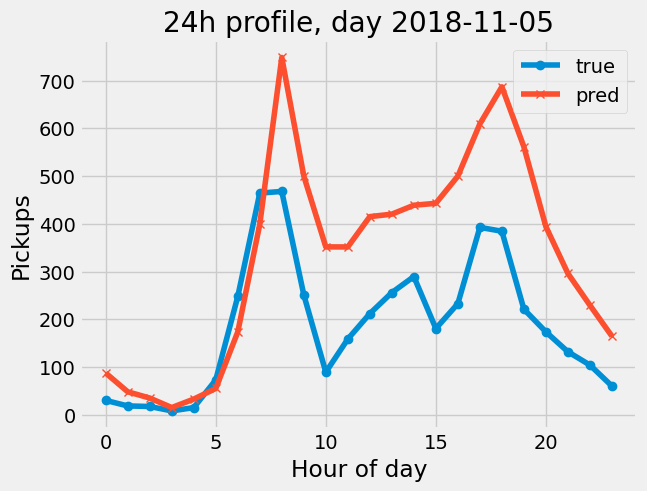

In [37]:
hours = np.arange(24)

n_plots =5   # first 5 test days, for example
for i in range(5):
    plt.figure()
    plt.plot(hours, y_test_inv[i], marker='o', label='true')
    plt.plot(hours, y_pred_inv[i], marker='x', label='pred')
    plt.xlabel('Hour of day')
    plt.ylabel('Pickups')
    plt.title(f'24h profile, day {test_dates[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()


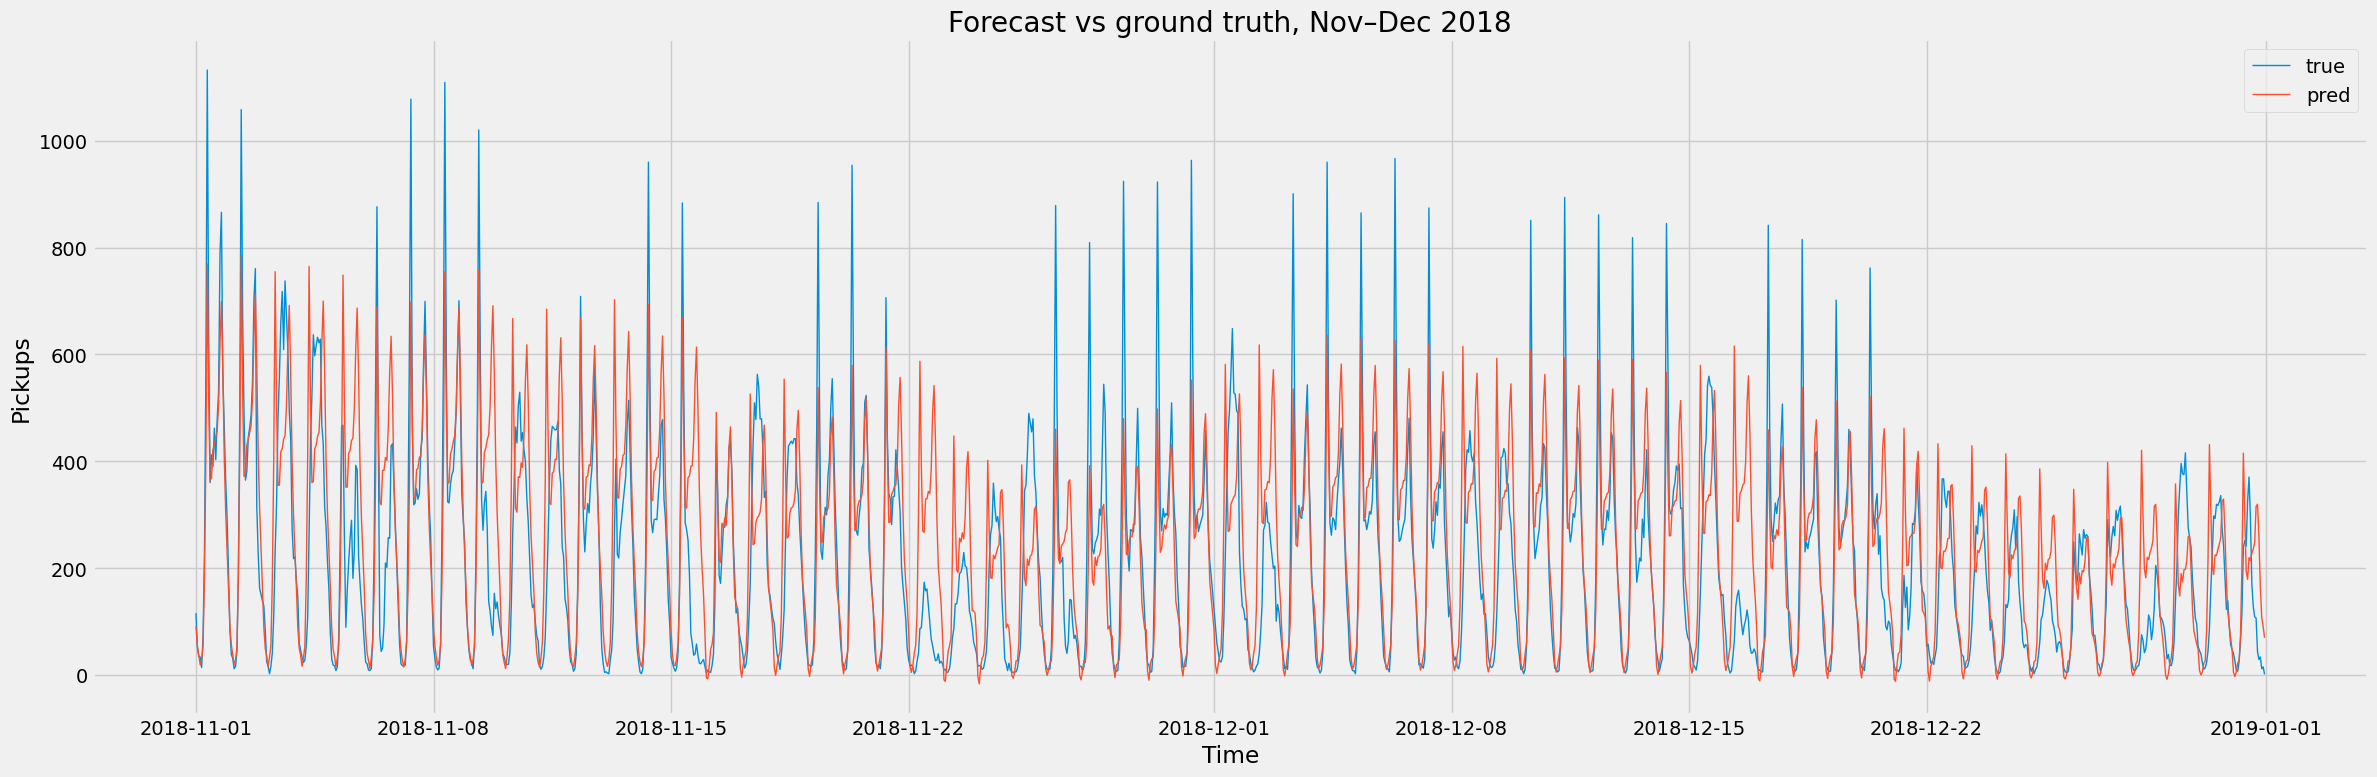

In [38]:
start = pd.to_datetime(test_dates[0])
full_index = pd.date_range(
    start=start,
    periods=24 * len(test_dates),
    freq='h'
)

true_series = y_test_inv.reshape(-1)
pred_series = y_pred_inv.reshape(-1)

plt.figure(figsize=(24, 8))
plt.plot(full_index, true_series, label='true', linewidth=1)
plt.plot(full_index, pred_series, label='pred', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.title('Forecast vs ground truth, Nov–Dec 2018')
plt.legend()
plt.tight_layout()
plt.show()


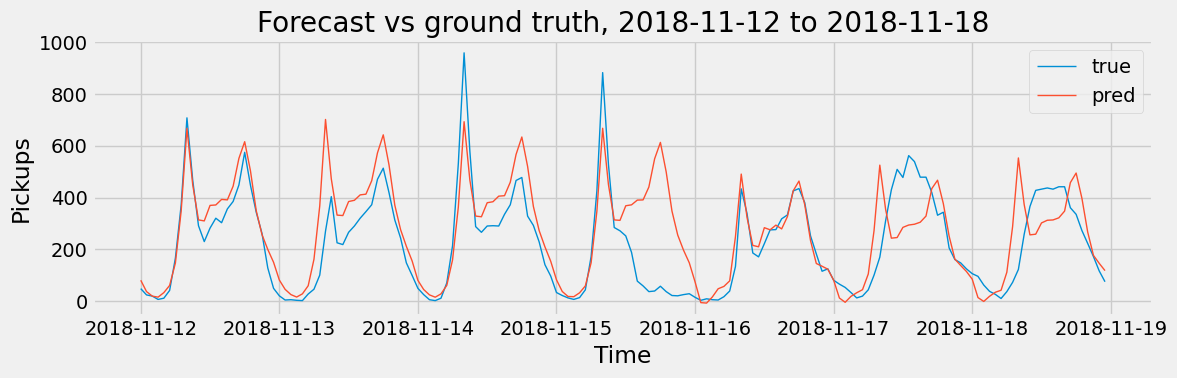

In [39]:
week_start = pd.to_datetime('2018-11-12')
week_end = week_start + pd.Timedelta(days=7)

mask = (full_index >= week_start) & (full_index < week_end)

week_index = full_index[mask]
week_true = true_series[mask]
week_pred = pred_series[mask]

plt.figure(figsize=(12, 4))
plt.plot(week_index, week_true, label='true', linewidth=1)
plt.plot(week_index, week_pred, label='pred', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.title('Forecast vs ground truth, 2018-11-12 to 2018-11-18')
plt.legend()
plt.tight_layout()
plt.show()


DROPOFFS

In [40]:
input_days = 7 
X_train_days, y_train, train_dates, X_test_days, y_test, test_dates = make_samples_with_dates(daily_values_dropoffs, dates_dropoffs, input_days=input_days)

In [41]:
val_size = 30  # days

X_train_days_final = X_train_days[:-val_size]
y_train_final       = y_train[:-val_size]

X_val_days          = X_train_days[-val_size:]
y_val               = y_train[-val_size:]

In [42]:
X_train = to_lstm_shape(X_train_days_final, input_days)
X_val   = to_lstm_shape(X_val_days,        input_days)
X_test  = to_lstm_shape(X_test_days,       input_days)

Config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001}
Epoch 1/50


c:\Users\user\Documents\GitHub\city-bike\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0615 - mae: 0.1823 - val_loss: 0.0758 - val_mae: 0.2099
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0430 - mae: 0.1555 - val_loss: 0.0391 - val_mae: 0.1573
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0244 - mae: 0.1211 - val_loss: 0.0227 - val_mae: 0.1152
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0184 - mae: 0.1020 - val_loss: 0.0162 - val_mae: 0.0958
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0124 - mae: 0.0798 - val_loss: 0.0111 - val_mae: 0.0751
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0113 - mae: 0.0747 - val_loss: 0.0094 - val_mae: 0.0682
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0089 - mae: 0.0647 - val_loss: 0.0079 - val_mae: 0.0614
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0088 - mae: 0.0641 - val_loss: 0.0076 - val_mae: 0.0591
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0079 - mae: 0.0590 - val_l

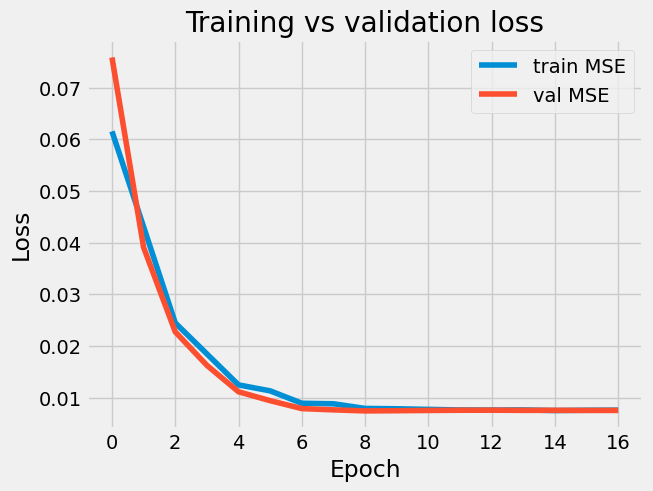

  best val_loss = 0.00741, epochs_used = 9
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.5, 'lr': 0.001}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - loss: 0.0420 - mae: 0.1581 - val_loss: 0.0322 - val_mae: 0.1539
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 0.0186 - mae: 0.1006 - val_loss: 0.0113 - val_mae: 0.0769
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0102 - mae: 0.0712 - val_loss: 0.0081 - val_mae: 0.0597
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0081 - mae: 0.0605 - val_loss: 0.0077 - val_mae: 0.0607
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0087 - mae: 0.0633 - val_loss: 0.0077 - val_mae: 0.0581
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0078 - mae: 0.0584 - val_loss: 0.0076 - val_mae: 0.0570
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0079 - mae: 0.0585 - val_loss: 0.0077 - val_mae: 0.0580
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0079 - mae: 0.05

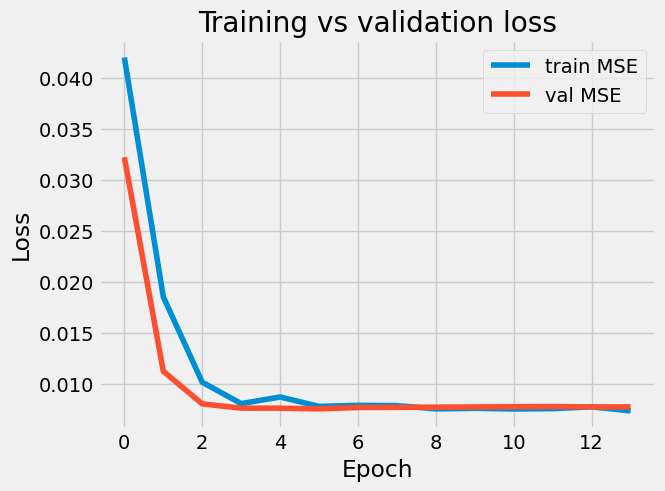

  best val_loss = 0.00758, epochs_used = 6
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.3, 'lr': 0.0005}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0594 - mae: 0.1792 - val_loss: 0.0686 - val_mae: 0.1981
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0352 - mae: 0.1404 - val_loss: 0.0332 - val_mae: 0.1504
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0210 - mae: 0.1098 - val_loss: 0.0179 - val_mae: 0.1033
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0129 - mae: 0.0845 - val_loss: 0.0111 - val_mae: 0.0745
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0093 - mae: 0.0657 - val_loss: 0.0081 - val_mae: 0.0612
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0086 - mae: 0.0627 - val_loss: 0.0076 - val_mae: 0.0581
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0080 - mae: 0.0598 - val_loss: 0.0074 - val_mae: 0.0574
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0082 - mae: 0.0

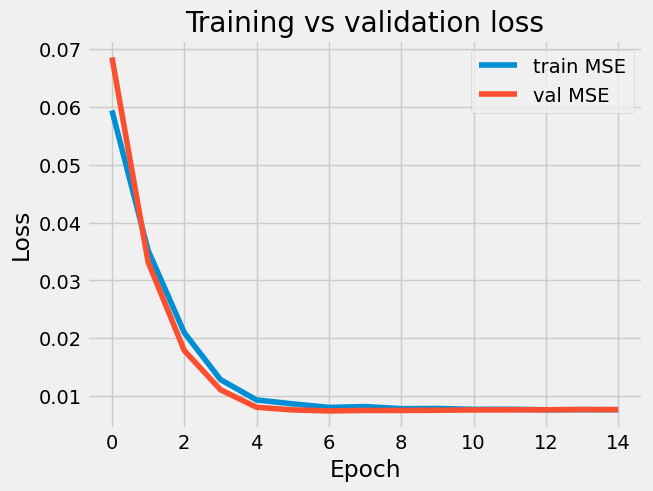

  best val_loss = 0.00743, epochs_used = 7
Best config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001} val_loss: 0.00740936491638422 best_epochs: 9


In [43]:
timesteps  = X_train.shape[1]   
n_features = X_train.shape[2]
best_cfg, best_epochs = perform_validation(timesteps, n_features)

In [44]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train_final, y_val], axis=0)

print(X_train_full.shape, y_train_full.shape)
# e.g. (297, 168, 1) and (297, 24)


(297, 168, 1) (297, 24)


In [45]:
final_model = build_model(
    units1=best_cfg['u1'],
    units2=best_cfg['u2'],
    dense_units=best_cfg['dense'],
    dropout_rate=best_cfg['drop'],
    lr=best_cfg['lr']
)

history_final = final_model.fit(
    X_train_full, y_train_full,
    epochs=best_epochs,   # from tuning
    batch_size=32,
    shuffle=False,
    verbose=1
)


Epoch 1/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0593 - mae: 0.1781
Epoch 2/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0417 - mae: 0.1488
Epoch 3/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0316 - mae: 0.1281
Epoch 4/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0243 - mae: 0.1117
Epoch 5/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0152 - mae: 0.0861
Epoch 6/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0122 - mae: 0.0790
Epoch 7/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0106 - mae: 0.0708
Epoch 8/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0081 - mae: 0.0591
Epoch 9/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0085 - mae: 0.0610


In [46]:
y_pred_scaled = final_model.predict(X_test)   # shape (N_test, 24)

# y_test and y_pred_scaled are in [0,1] (scaled)
# we need 2D arrays for scaler.inverse_transform

y_test_flat_scaled = y_test.reshape(-1, 1)
y_pred_flat_scaled = y_pred_scaled.reshape(-1, 1)

y_test_flat = scaler.inverse_transform(y_test_flat_scaled).ravel()
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).ravel()

# reshape back to (N_days, 24)
y_test_inv = y_test_flat.reshape(y_test.shape)
y_pred_inv = y_pred_flat.reshape(y_pred_scaled.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


In [47]:
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae  = mean_absolute_error(y_test_flat, y_pred_flat)

print(f'Overall RMSE: {rmse:.2f}')
print(f'Overall MAE:  {mae:.2f}')


Overall RMSE: 119.17
Overall MAE:  75.82


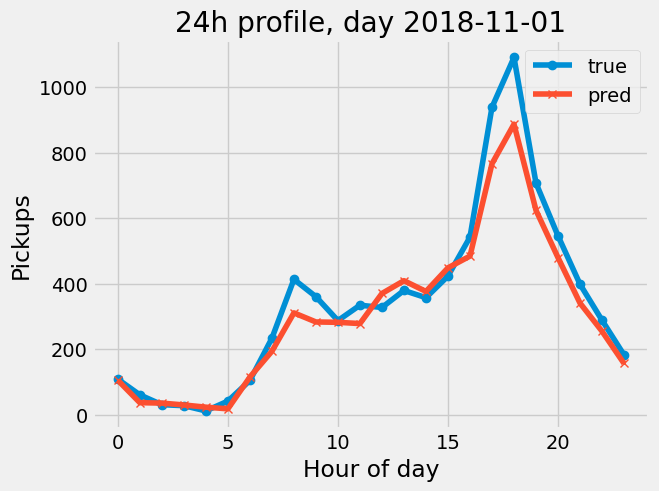

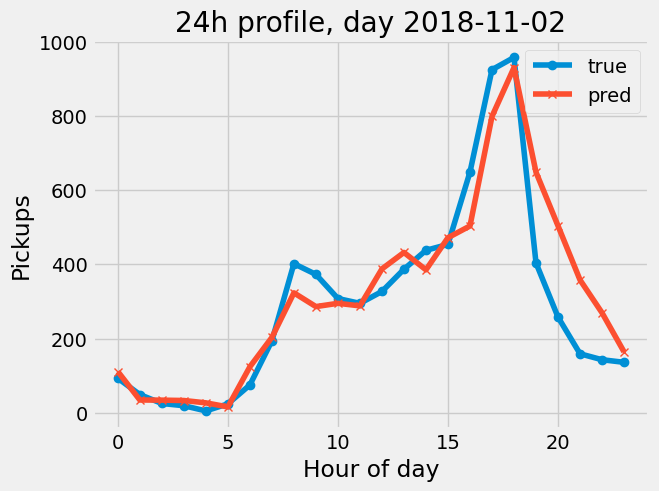

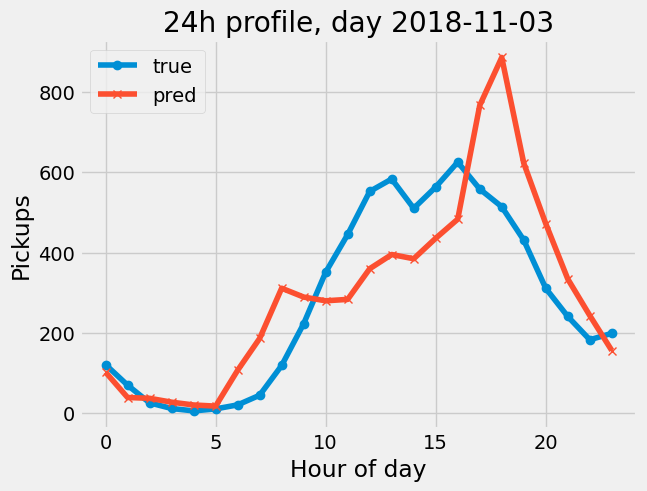

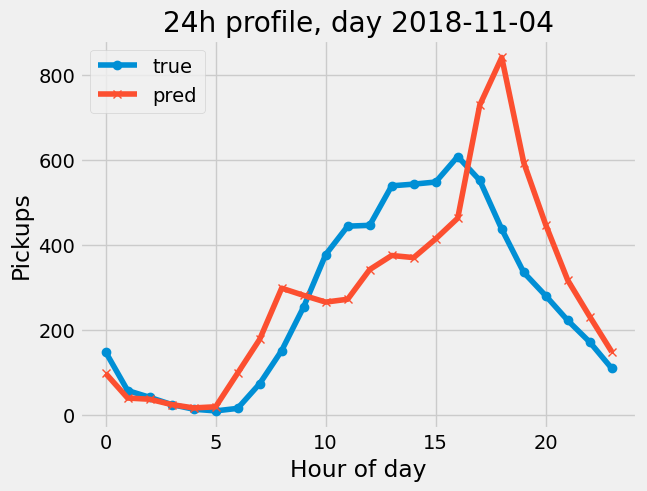

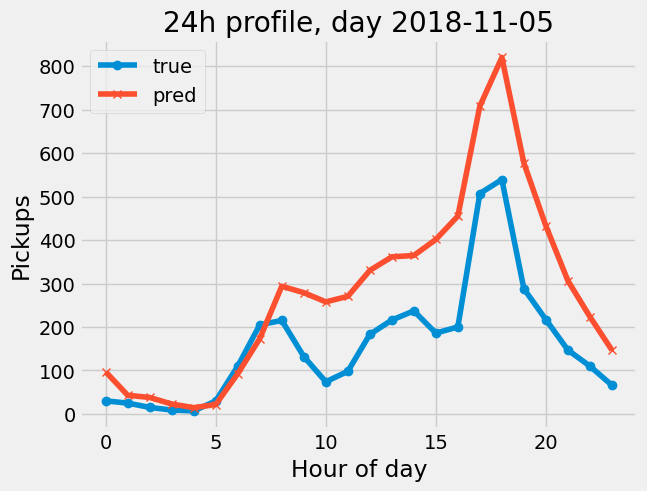

In [48]:
hours = np.arange(24)

n_plots =5   # first 5 test days, for example
for i in range(5):
    plt.figure()
    plt.plot(hours, y_test_inv[i], marker='o', label='true')
    plt.plot(hours, y_pred_inv[i], marker='x', label='pred')
    plt.xlabel('Hour of day')
    plt.ylabel('Pickups')
    plt.title(f'24h profile, day {test_dates[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()


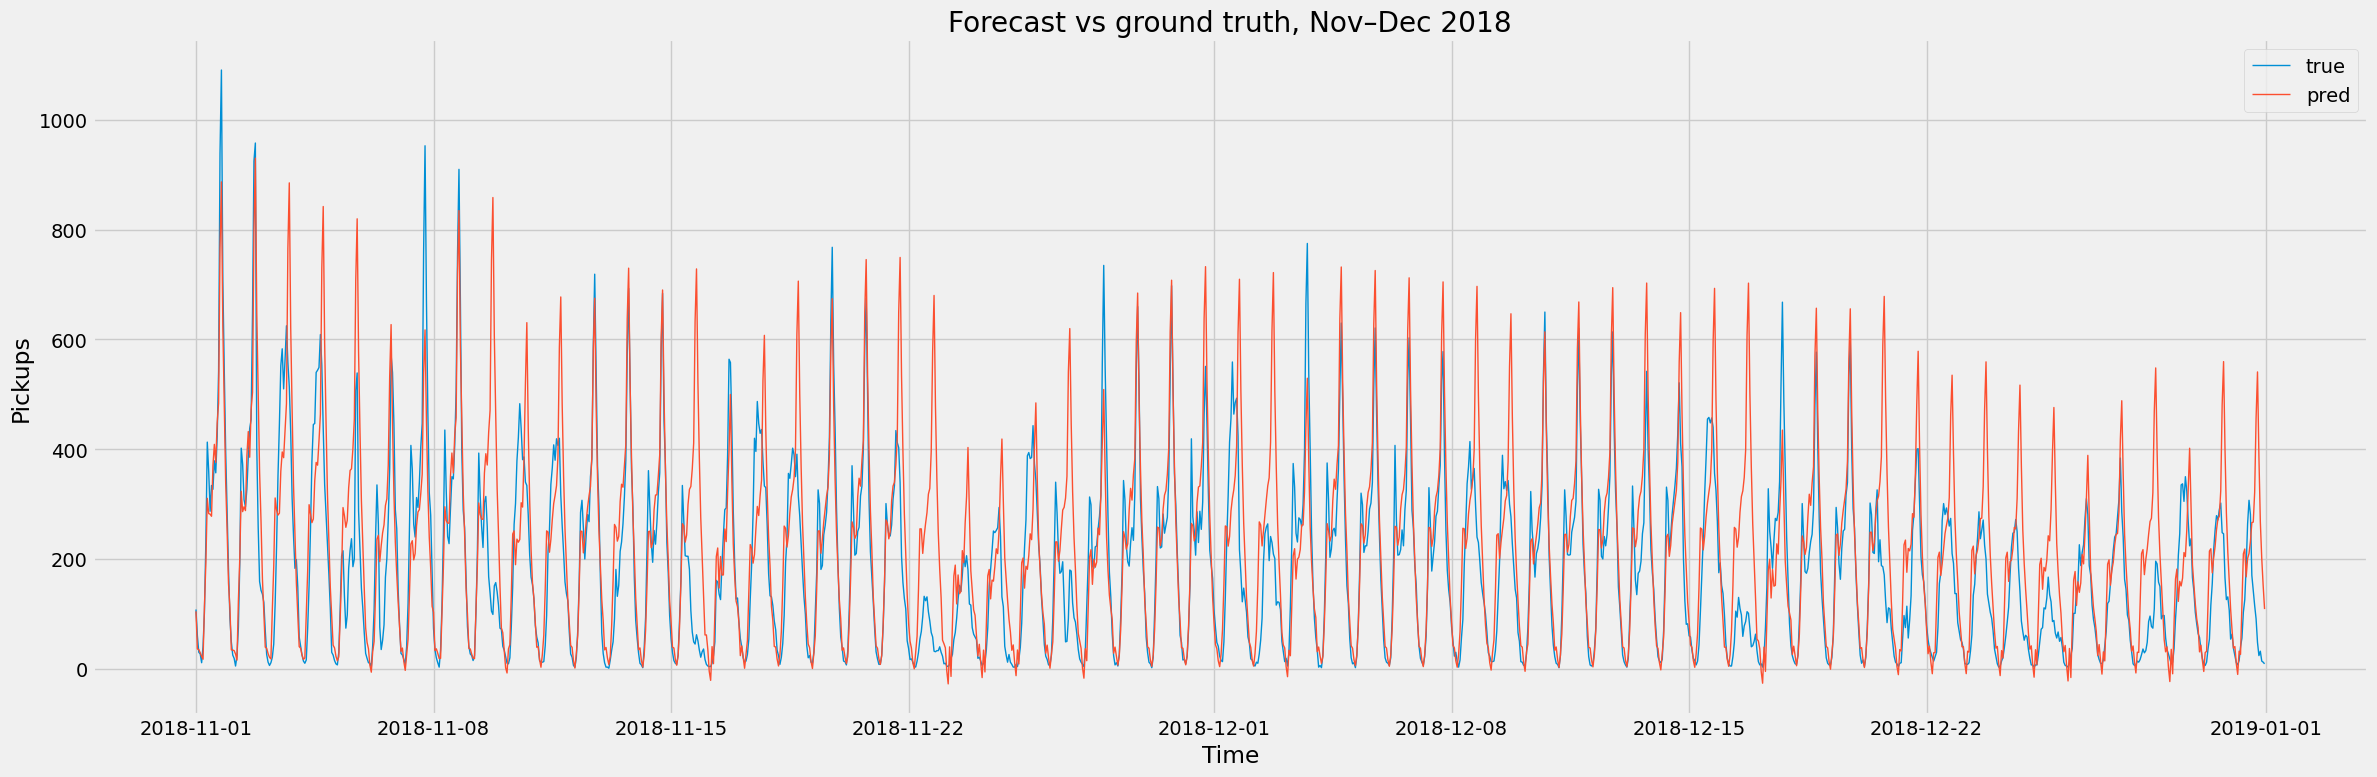

In [49]:
start = pd.to_datetime(test_dates[0])
full_index = pd.date_range(
    start=start,
    periods=24 * len(test_dates),
    freq='h'
)

true_series = y_test_inv.reshape(-1)
pred_series = y_pred_inv.reshape(-1)

plt.figure(figsize=(24, 8))
plt.plot(full_index, true_series, label='true', linewidth=1)
plt.plot(full_index, pred_series, label='pred', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.title('Forecast vs ground truth, Nov–Dec 2018')
plt.legend()
plt.tight_layout()
plt.show()


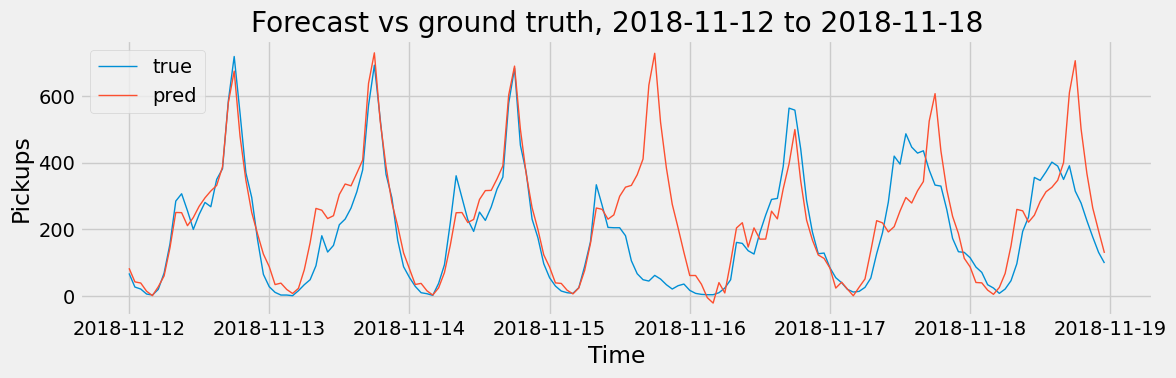

In [50]:
week_start = pd.to_datetime('2018-11-12')
week_end = week_start + pd.Timedelta(days=7)

mask = (full_index >= week_start) & (full_index < week_end)

week_index = full_index[mask]
week_true = true_series[mask]
week_pred = pred_series[mask]

plt.figure(figsize=(12, 4))
plt.plot(week_index, week_true, label='true', linewidth=1)
plt.plot(week_index, week_pred, label='pred', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.title('Forecast vs ground truth, 2018-11-12 to 2018-11-18')
plt.legend()
plt.tight_layout()
plt.show()


## 4. Model Comparison

## 5. Net Flow Prediction

This implementation is more interactive. We let the user pick the date they want to predict the number of bikes that need to be repositioned. Then, we dynamically select train and test dataset and use timeseries to find the hourly net flow of the cluster.

In [100]:
hourly_2018_pickups = chd_2018.loc['2018-01-01':'2018-12-31 23:00','pickups']
hourly_2018_dropoffs = chd_2018_drop.loc['2018-01-01':'2018-12-31 23:00','dropoffs']
hourly_2018_pickups_dropoffs = pd.concat([hourly_2018_pickups,hourly_2018_dropoffs], axis=1)
hourly_2018_pickups_dropoffs.head()

,pickups,dropoffs
datetime,,
2018-01-01 00:00:00,7.0,5.0
2018-01-01 01:00:00,4.0,2.0
2018-01-01 02:00:00,2.0,3.0
2018-01-01 03:00:00,1.0,0.0
2018-01-01 04:00:00,2.0,2.0


In the following user prompt, you should type '2018-11-01', to continue with the same split of train/test data as we have used in **2.1.1 1 & 2.1.2**. Feel free to experiment with different dates, as well. 

In [101]:
# Prompt the user to input the date
date_input = input("Enter the date for which you want to predict reposition needs (2018-MM-DD): ")

# Parse the input as a datetime
import datetime
try:
    target_date = datetime.datetime.strptime(date_input, "%Y-%m-%d").date()
    print(f"Processing reposition needs for: {target_date}")
except ValueError:
    print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

Processing reposition needs for: 2018-11-01


In [102]:
# Train data: Strictly before the given date
# Test data: Includes all dates from the input date and after
train_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'pickups']
test_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'pickups']

train_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'dropoffs']
test_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'dropoffs']


# Fit ARIMA model for this cluster
model1 = SARIMAX(train_net_pick, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted1 = model1.fit(disp=False)

model2 = SARIMAX(train_net_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted2 = model2.fit(disp=False)

# Forecast next 24 hours pickups and dropoffs
fc_pickups = fitted1.forecast(steps=24)
fc_dropoffs = fitted2.forecast(steps=24)


In [103]:
picks_forecast_df = pd.DataFrame(fc_pickups)
picks_forecast_df.columns = ['pickups']
picks_forecast_df.index.name = 'datetime'
#picks_forecast_df.info()

drops_forecast_df = pd.DataFrame(fc_dropoffs)
drops_forecast_df.columns = ['dropoffs']
drops_forecast_df.index.name = 'datetime'
#drops_forecast_df.info()

# Combine forecasts into one DataFrame
forecast_next_day = pd.concat([picks_forecast_df, drops_forecast_df], axis=1)
forecast_next_day

,pickups,dropoffs
datetime,,
2018-11-01 00:00:00,16.314858,9.824030
2018-11-01 01:00:00,9.834879,5.768100
2018-11-01 02:00:00,5.537352,3.431264
2018-11-01 03:00:00,3.130356,2.085418
2018-11-01 04:00:00,5.099619,2.470101
2018-11-01 05:00:00,25.426136,12.217690
2018-11-01 06:00:00,76.537570,28.843112
2018-11-01 07:00:00,166.271185,39.683921
2018-11-01 08:00:00,241.294431,45.314180


In [104]:
# Calculate net flow: pickups = departures
net_flow = forecast_next_day['pickups'] - forecast_next_day['dropoffs']
forecast_next_day['net'] = net_flow
forecast_next_day



,pickups,dropoffs,net
datetime,,,
2018-11-01 00:00:00,16.314858,9.824030,6.490828
2018-11-01 01:00:00,9.834879,5.768100,4.066779
2018-11-01 02:00:00,5.537352,3.431264,2.106089
2018-11-01 03:00:00,3.130356,2.085418,1.044938
2018-11-01 04:00:00,5.099619,2.470101,2.629518
2018-11-01 05:00:00,25.426136,12.217690,13.208446
2018-11-01 06:00:00,76.537570,28.843112,47.694458
2018-11-01 07:00:00,166.271185,39.683921,126.587264
2018-11-01 08:00:00,241.294431,45.314180,195.980251


In [109]:
mask = forecast_next_day.index.date == target_date
day_netflow = forecast_next_day.loc[mask, 'net'].max()

# Required bikes at start of day
required_bikes = math.ceil(max(0, day_netflow))
print(f"Number of bikes to reposition on {target_date} for cluster {target_clusters[0]} is: {required_bikes}")

Number of bikes to reposition on 2018-11-01 for cluster 3 is: 196
